In [ ]:
import os
import librosa
import librosa.display as ld
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import scipy.ndimage as ndimage
from itertools import groupby, accumulate
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from scipy.ndimage import binary_closing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Обработка

Скачивание датасета с аудио

In [ ]:
! kaggle competitions download -c morse-decoder

morse-decoder.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
df = pd.read_csv("morse-decoder/train.csv")
df = df.set_index('id')

In [ ]:
df

,message
id,
1.opus,03ЩУЫЛПИГХ
2.opus,ЪЛТ0ДС6А3Г
3.opus,5ЭКЫБЗХЯН
4.opus,ЖЫЦОИ68КФ
5.opus,32Ю7МЫ ЗЛ
...,...
29996.opus,ЬДТРЭ 9М6М
29997.opus,ЬКТ1 ШЭЪ
29998.opus,ЫВЙЗБЯН7К


Заготовка методов для декодировки. Разведочный анализ показал, что кодировка, используемая в датасете, отличается от обыкновенной кириллической морзянки, например, "Ъ" кодируется иначе. Также присутствует знак "#".

In [ ]:
morse_to_char = {
    '.-': 'А',
    '-...': 'Б',
    '.--': 'В',
    '--.': 'Г',
    '-..': 'Д',
    '.': 'Е',
    '...-': 'Ж',
    '--..': 'З',
    '..': 'И',
    '.---': 'Й',
    '-.-': 'К',
    '.-..': 'Л',
    '--': 'М',
    '-.': 'Н',
    '---': 'О',
    '.--.': 'П',
    '.-.': 'Р',
    '...': 'С',
    '-': 'Т',
    '..-': 'У',
    '..-.': 'Ф',
    '....': 'Х',
    '-.-.': 'Ц',
    '---.': 'Ч',
    '----': 'Ш',
    '--.-': 'Щ',
    '--.--': '#',
    '.--.-.': 'Ъ',
    '-.--': 'Ы',
    '-..-': 'Ь',
    '..-..': 'Э',
    '..--': 'Ю',
    '.-.-': 'Я',
    ' ': ' ',
    '-----': '0',
    '.----': '1',
    '..---': '2',
    '...--': '3',
    '....-': '4',
    '.....': '5',
    '-....': '6',
    '--...': '7',
    '---..': '8',
    '----.': '9',
}

char_to_morse = dict()
for morse, char in morse_to_char.items():
    char_to_morse[char] = morse
char_to_morse

def message_to_morze(message):
    morse_code = [char_to_morse[char] for char in message if char in char_to_morse]
    return " ".join(morse_code)

def morze_to_message(morse_str):
    words = morse_str.strip().split("   ")  # разделяем слова (три пробела)
    decoded_words = []

    for word in words:
        chars = word.split(" ")  # разделяем буквы (один пробел)
        decoded_chars = [morse_to_char.get(char, '') for char in chars]
        decoded_words.append("".join(decoded_chars))

    return " ".join(decoded_words)

Разведочный анализ: смотрим как выглядят данные и пытаемся обработать один образец

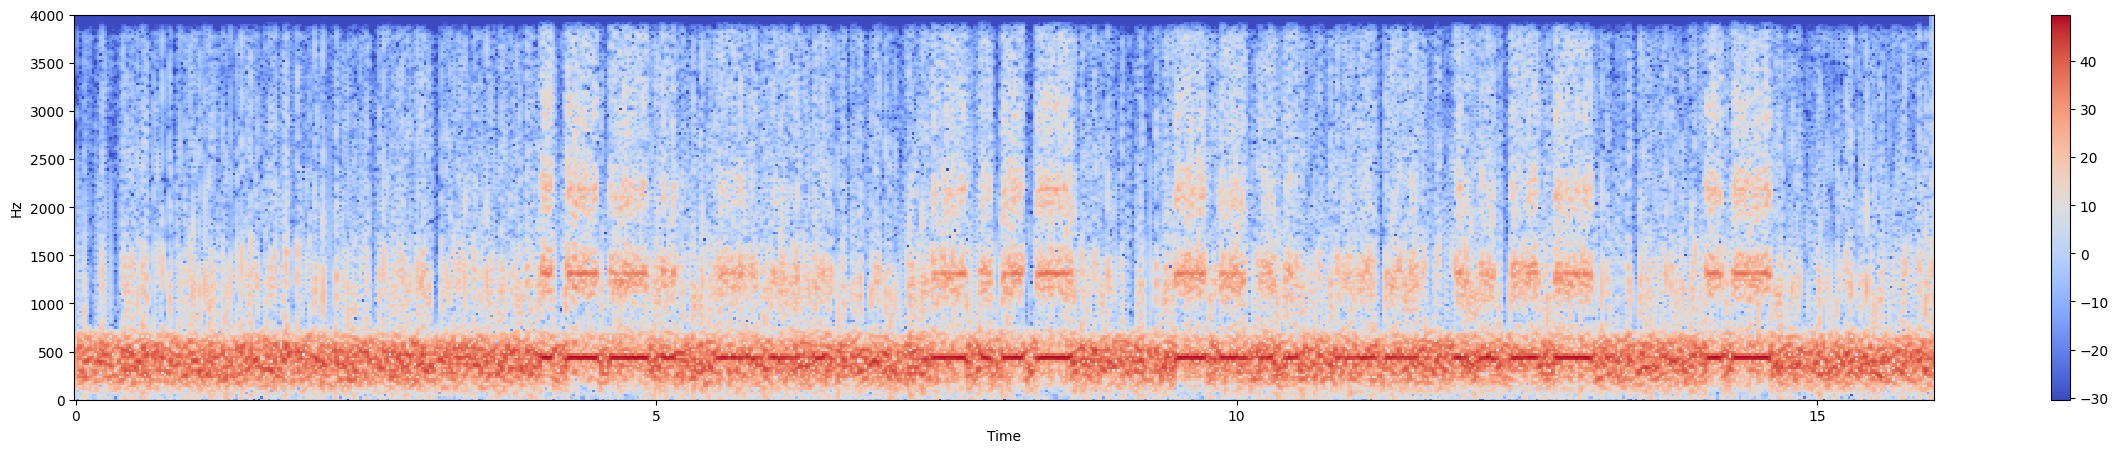

In [ ]:
signal, sr = librosa.load(f"morse-decoder/morse_dataset/morse_dataset/79.opus", sr = 24000)
stft = librosa.stft(signal, n_fft=1024, hop_length=256)
s = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(30, 5))
plt.ylim(0, 4000)
ld.specshow(s, sr=sr, x_axis = 'time', y_axis='linear')
plt.colorbar()

Фильтрация и преобразования

In [ ]:
from scipy.signal import butter, lfilter

y, sr = librosa.load(f"morse-decoder/morse_dataset/morse_dataset/79.opus")

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

filtered_y = lfilter(*butter_bandpass(100, 2000, sr), y)

In [ ]:
normalized_y = librosa.util.normalize(filtered_y)
S = librosa.feature.melspectrogram(y=normalized_y, sr=sr)
S_db = librosa.amplitude_to_db(S, ref=np.max)

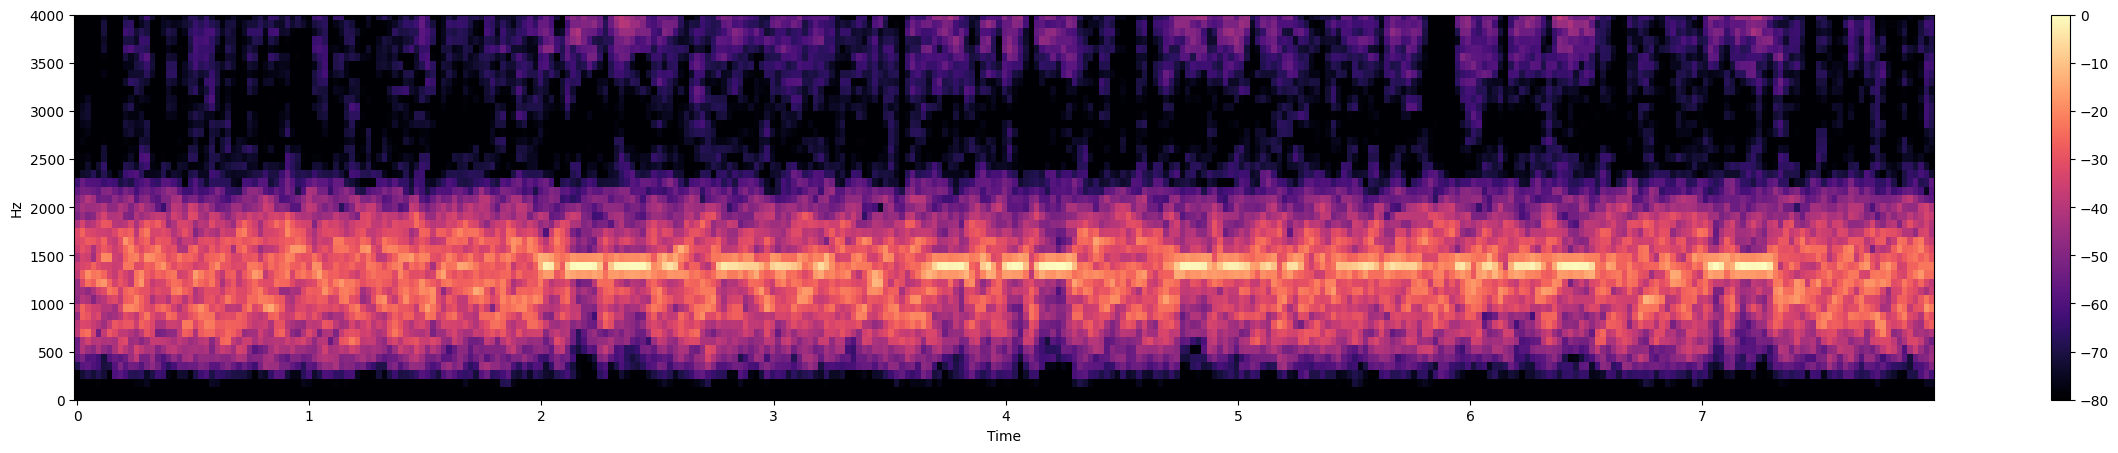

In [ ]:
plt.figure(figsize=(30, 5))
plt.ylim(0, 4000)
ld.specshow(S_db, sr=sr, x_axis = 'time', y_axis='linear')
plt.colorbar()

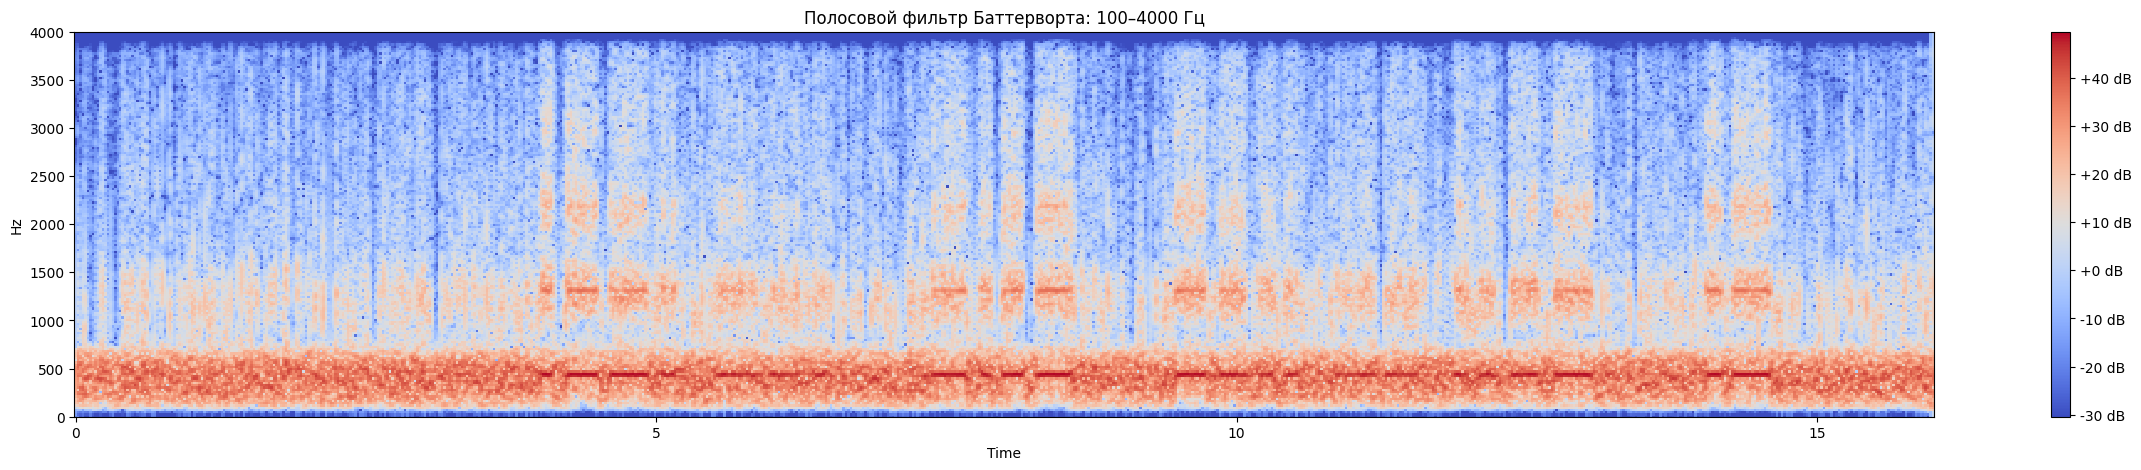

In [ ]:
import librosa
import librosa.display as ld
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt

# Загрузка аудио
signal, sr = librosa.load("morse-decoder/morse_dataset/morse_dataset/79.opus", sr=24000)

# === Шаг 1: Определим полосовой фильтр Баттерворта ===
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs  # частота Найквиста
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# === Шаг 2: Применим фильтр ===
lowcut =  100 # нижняя граница полосы (в Гц)
highcut = 4000  # верхняя граница полосы (в Гц)

filtered_signal = apply_bandpass_filter(signal, lowcut, highcut, sr, order=6)

# === Шаг 3: STFT и отображение ===
stft = librosa.stft(filtered_signal, n_fft=1024, hop_length=256)
s = librosa.amplitude_to_db(np.abs(stft))

plt.figure(figsize=(30, 5))
plt.ylim(0, 4000)
ld.specshow(s, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar(format="%+2.0f dB")
plt.title('Полосовой фильтр Баттерворта: {}–{} Гц'.format(lowcut, highcut))
plt.show()

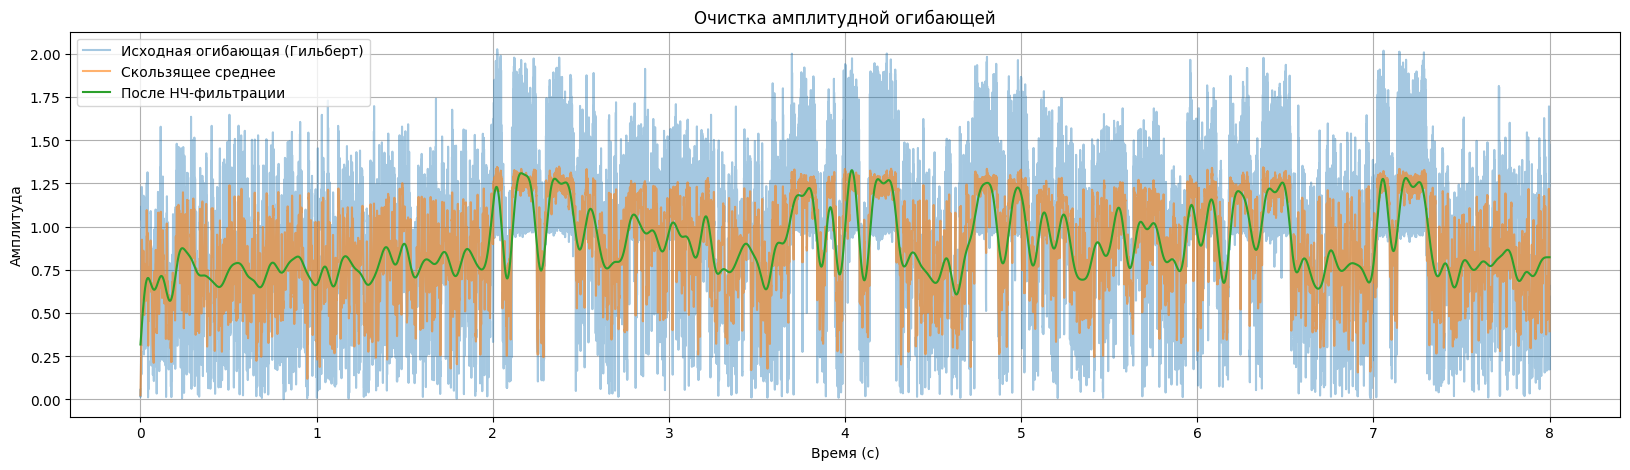

In [ ]:
from scipy.signal import butter, filtfilt, hilbert
import numpy as np
import matplotlib.pyplot as plt

# === 1. Преобразование Гильберта (огибающая) ===
analytic_signal = hilbert(filtered_signal)
amplitude_envelope = np.abs(analytic_signal)

# === 2. Скользящее среднее ===
def moving_average(signal, window_size):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='same')

smoothed_envelope = moving_average(amplitude_envelope, window_size=100)

# === 3. Низкочастотный фильтр Баттерворта ===
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low')
    return b, a

def apply_lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order)
    y = filtfilt(b, a, data)
    return y

# Применим НЧ-фильтр (например, ниже 10 Гц, чтобы убрать колебания огибающей)
filtered_envelope = apply_lowpass_filter(smoothed_envelope, cutoff=10, fs=sr)

# === 4. Визуализация ===
time = np.arange(len(filtered_envelope)) / sr

plt.figure(figsize=(20, 5))
plt.plot(time, amplitude_envelope, alpha=0.4, label='Исходная огибающая (Гильберт)')
plt.plot(time, smoothed_envelope, alpha=0.6, label='Скользящее среднее')
plt.plot(time, filtered_envelope, label='После НЧ-фильтрации')
plt.title("Очистка амплитудной огибающей")
plt.xlabel("Время (с)")
plt.ylabel("Амплитуда")
plt.grid(True)
plt.legend()
plt.show()

Попытка получить из временного ряда метки (0 - тишина, 1 - сигнал)

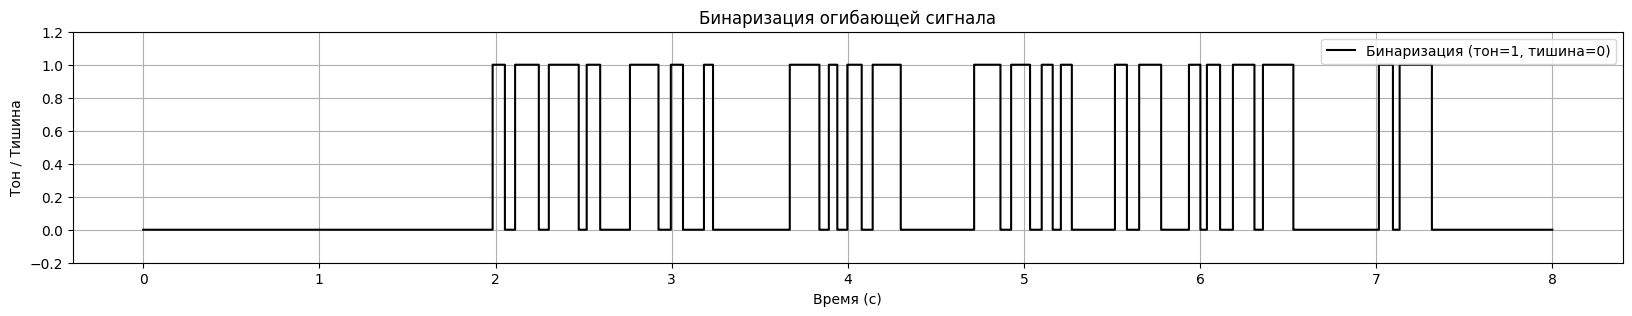

In [ ]:
from skimage.filters import threshold_otsu
from skimage.filters import threshold_li
from skimage.filters import threshold_yen
from skimage.filters import threshold_local

# Вычисляем порог по методу Отсу
# threshold = threshold_otsu(filtered_envelope)
threshold = threshold_otsu(filtered_envelope)

binary_mask = filtered_envelope > threshold

# Визуализация бинарной маски
plt.figure(figsize=(20, 3))
plt.plot(time, binary_mask.astype(int), drawstyle='steps-post', color='black', label='Бинаризация (тон=1, тишина=0)')
plt.title("Бинаризация огибающей сигнала")
plt.xlabel("Время (с)")
plt.ylabel("Тон / Тишина")
plt.ylim(-0.2, 1.2)
plt.grid(True)
plt.legend()
plt.show()

Получение признаков из временного ряда, полученный датасет должен выглядеть как набор пар (сигнал/тишина, длительность). Например, (1, 1300) - сигнал длится 1300 условных единиц времени (фреймов), а (0, 500) - тишина длится 500 единиц времени. Таким образом, датасет состоит из строго чередующихся пар сигнал/тишина и времени этого сигнала/тишины.   

In [ ]:
from itertools import groupby, accumulate

# Группировка последовательных значений
groups_raw = [(val, sum(1 for _ in group)) for val, group in groupby(binary_mask)]

# Получаем кумулятивную сумму длительностей
lengths = [length for _, length in groups_raw]
cumulative = list(accumulate(lengths))

# Добавляем накопительную сумму как третий элемент (сдвинутую на 1 назад, чтобы соответствовать началу блока)
groups = [(val, length, cumulative[i] - length) for i, (val, length) in enumerate(groups_raw)]

#adjusted = [(1 - val if length <= noise_length else val, length) for val, length in groups_raw]

# Шаг 2: сгруппировать заново по подряд идущим одинаковым значениям
# recombined = []
# for val, group in groupby(adjusted, key=lambda x: x[0]):
#     total_length = sum(length for _, length in group)
#     recombined.append((val, total_length))

# # Шаг 3: накопительная сумма
# lengths = [length for _, length in groups]
# cumulative = list(accumulate(lengths))
# groups = [(val, length, cumulative[i] - length) for i, (val, length) in enumerate(groups)]

if groups[0][0] == 0:
    groups = groups[1:]
if groups[-1][0] == 0:
    groups.pop()
    durations = [d for (_, d, _) in groups]
    groups.append((np.False_, max(durations), 0))

Вычисленные максимальные и минимальные значения длительности сигнала в ходе разведочного анализа, для масштабирования [0,1]

In [ ]:
min_d_n = 9
max_d_n = 71729

In [ ]:
# durations = [d for (_, d, _) in groups]
# # sum_d = sum(durations)
# min_d = min(durations)
# max_d = max(durations)

# Масштабируем
normalized_groups = [(val, (d - min_d_n) / (max_d_n - min_d_n)) for val, d, _ in groups]
normalized_groups

[(np.True_, 0.022546012269938652),
 (np.False_, 0.020580033463469045),
 (np.True_, 0.02456776352481874),
 (np.False_, 0.019088120468488567),
 (np.True_, 0.061977133296151704),
 (np.False_, 0.021737311767986614),
 (np.True_, 0.017582264361405465),
 (np.False_, 0.021388733965421083),
 (np.True_, 0.021012269938650307),
 (np.False_, 0.060443390964863355),
 (np.True_, 0.05415504740658115),
 (np.False_, 0.057166759620747354),
 (np.True_, 0.04997211377579476),
 (np.False_, 0.01954824316787507),
 (np.True_, 0.04739263803680981),
 (np.False_, 0.018892916899051867),
 (np.True_, 0.01871165644171779),
 (np.False_, 0.01900446179587284),
 (np.True_, 0.030870050195203568),
 (np.False_, 0.026003904071388733),
 (np.True_, 0.05522866703848299),
 (np.False_, 0.07398215281650865),
 (np.True_, 0.01921360847741216),
 (np.False_, 0.018627997769102064),
 (np.True_, 0.018544339096486336),
 (np.False_, 0.01409648633575014),
 (np.True_, 0.06391522587841607),
 (np.False_, 0.019394868934746234),
 (np.True_, 0.0212

Будем классифицировать сигналы следующим образом: сначала попытаемся кластеризовать по длительности сигнал. Сигнал может быть только двух видов - точка (короткий сигнал) и тире (длинный сигнал). Внутри одного аудио разные типы сигналов хорошо отделяются.

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Извлекаем длительности только сигналов (1-сегментов)
signal_durations = [d for v, d in normalized_groups if v == 1]
signal_durations_np = np.array(signal_durations).reshape(-1, 1)

# Кластеризуем на 2 или 3 группы
kmeans = KMeans(n_clusters=2, random_state=0).fit(signal_durations_np)
thresholds = sorted([np.mean(signal_durations_np[kmeans.labels_ == i]) for i in range(2)])

# Порог 1: конец символа; порог 2: конец слова
dot_kmeans = thresholds[0]
dash_kmeans = thresholds[1]

# median_pause = np.median(signal_durations_np)
# letter_threshold_emp = median_pause * 1.5
# word_threshold_emp = median_pause * 3

# letter_threshold = (letter_threshold_kmeans + letter_threshold_emp) / 2
# word_threshold = (word_threshold_kmeans + word_threshold_emp) / 2

print(dot_kmeans)
print(dash_kmeans)

0.02188969006453669
0.058767119043192664


Попытка кластеризовать тишину. Тишина бывает трех видов - тишина между точками и тире внутри одной буквы (самая короткая тишина), тишина между различными буквами (более длинная тишина), тишина, отвечающая за пробел (самая длинная тишина). Разведочный анализ показал, что самая длинная тишина всегда превышает 0.1 времени. 

In [ ]:
silence_durations = [d for v, d in normalized_groups if v == 0 and d < 0.1]
silence_durations_np = np.array(silence_durations).reshape(-1, 1)

# Кластеризуем на 2 или 3 группы
kmeans_silence = KMeans(n_clusters=2, random_state=0).fit(silence_durations_np)
thresholds_silence = sorted([np.mean(silence_durations_np[kmeans_silence.labels_ == i]) for i in range(2)])

in_letter_kmeans = thresholds_silence[0]
letter_kmeans = thresholds_silence[1]

print(in_letter_kmeans)
print(letter_kmeans)

0.020963469046291133
0.06889117401003904


In [ ]:
def classify_pause(duration):
    """Определяет тип паузы по близости к кластерным порогам."""
    distances = {
        'in_letter': abs(duration - in_letter_kmeans),
        'letter': abs(duration - letter_kmeans)
    }
    return min(distances, key=distances.get)

In [ ]:
def classify_signal(duration):
    """Определяет тип сигнала по близости к кластерным порогам."""
    distances = {
        'dot': abs(duration - dot_kmeans),
        'dash': abs(duration - dash_kmeans)
    }
    return min(distances, key=distances.get)

Перевод в точки и тире и паузы.

In [ ]:
groups_with_marks = []

for signal, dur in normalized_groups:

    if signal == 0:
      if dur > 0.1:
        space = "space"
      else:
        space = classify_pause(dur)
      groups_with_marks.append((signal, dur, space))

    elif signal == 1:
      symbol = classify_signal(dur)
      groups_with_marks.append((signal, dur, symbol))

Разделяем аудио на слова и буквы следующим образом: в кодировке не может быть более 6 символов ("Ъ" кодируется 6 знаками, остальные меньшим количеством) без длинного пробела подряд. Мы должны это учитывать, выискивая самые длинные пробелы в окне из 6 идущих подряд пробелов и делить по ним буквы. 

In [ ]:
# Получаем только False-элементы с их индексами в оригинальном списке
lst = groups_with_marks
false_elements = [(i, item) for i, item in enumerate(lst) if not item[0]]

i = 0
while i < len(false_elements):
    # Берём 6 подряд идущих false-элементов
    window = false_elements[i:i+6]
    if len(window) < 6:
        break

    # Проверяем, есть ли уже 'letter' в окне
    if any(item[2] == 'letter' for _, item in window):
        # Находим индекс первого 'letter' и начинаем после него
        for offset, (_, item) in enumerate(window):
            if item[2] == 'letter':
                i += offset + 1
                break
        continue

    # Ищем максимум по второму значению
    max_entry = max(window, key=lambda x: x[1][1])
    max_index_in_lst = max_entry[0]

    # Меняем 'in_letter' на 'letter' в оригинальном списке
    old_item = lst[max_index_in_lst]
    lst[max_index_in_lst] = (old_item[0], old_item[1], 'letter')

    # Переходим к следующему элементу после максимума
    i = [j for j, _ in false_elements].index(max_index_in_lst) + 1

# Вывод результата
for item in lst:
    print(item)

(np.True_, 0.022546012269938652, 'dot')
(np.False_, 0.020580033463469045, 'in_letter')
(np.True_, 0.02456776352481874, 'dot')
(np.False_, 0.019088120468488567, 'in_letter')
(np.True_, 0.061977133296151704, 'dash')
(np.False_, 0.021737311767986614, 'in_letter')
(np.True_, 0.017582264361405465, 'dot')
(np.False_, 0.021388733965421083, 'in_letter')
(np.True_, 0.021012269938650307, 'dot')
(np.False_, 0.060443390964863355, 'letter')
(np.True_, 0.05415504740658115, 'dash')
(np.False_, 0.057166759620747354, 'letter')
(np.True_, 0.04997211377579476, 'dash')
(np.False_, 0.01954824316787507, 'in_letter')
(np.True_, 0.04739263803680981, 'dash')
(np.False_, 0.018892916899051867, 'in_letter')
(np.True_, 0.01871165644171779, 'dot')
(np.False_, 0.01900446179587284, 'in_letter')
(np.True_, 0.030870050195203568, 'dot')
(np.False_, 0.026003904071388733, 'in_letter')
(np.True_, 0.05522866703848299, 'dash')
(np.False_, 0.07398215281650865, 'letter')
(np.True_, 0.01921360847741216, 'dot')
(np.False_, 0.018

Окончательный перевод

In [ ]:
morse_result = ""

for signal, dur, mark in groups_with_marks:
  if signal == 1:
    if mark == 'dash':
      morse_result += '-'
    elif mark == 'dot':
      morse_result += '.'
  else:
    if dur > 0.1:
      morse_result += "   "
    elif mark == 'letter':
      morse_result += " "

print(morse_result.strip())

..-.. - --..- ..-.- --.- .--- .--. -.--


In [ ]:
morze_to_message(morse_result.strip())

'ЭТЩЙПЫ'

In [ ]:
df.loc['191.opus']['message']

'ЭТ#ФТЩШПЫ'

Собираем все этапы обработки уже для каждого аудио 

In [ ]:
X_test = []

for file_name in tqdm(range(30001,35000+1)):
    signal, sr = librosa.load(f"morse-decoder/morse_dataset/morse_dataset/{file_name}.opus", sr = 24000)

    stft = librosa.stft(signal, n_fft=1024, hop_length=256)
    s = librosa.amplitude_to_db(np.abs(stft))

    analytic_signal = hilbert(signal)
    amplitude_envelope = np.abs(analytic_signal)

    smoothed_envelope = moving_average(amplitude_envelope, window_size=100)
    filtered_envelope = apply_lowpass_filter(smoothed_envelope, cutoff=10, fs=sr)

    threshold = threshold_otsu(filtered_envelope)

    binary_mask = filtered_envelope > threshold

    groups_raw = [(val, sum(1 for _ in group)) for val, group in groupby(binary_mask)]

    lengths = [length for _, length in groups_raw]
    cumulative = list(accumulate(lengths))

    groups = [(val, length, cumulative[i] - length) for i, (val, length) in enumerate(groups_raw)]

    if groups[0][0] == 0:
        groups = groups[1:]
    if groups[-1][0] == 0:
        groups.pop()
        durations = [d for (_, d, _) in groups]
        groups.append((np.False_, max(durations), 0))

    normalized_groups = [(val, (d - min_d_n) / (max_d_n - min_d_n)) for val, d, _ in groups]
    X_test.append(normalized_groups)

    signal_durations = [d for v, d in normalized_groups if v == 1]
    signal_durations_np = np.array(signal_durations).reshape(-1, 1)

    # Кластеризуем на 2 или 3 группы
    kmeans = KMeans(n_clusters=2, random_state=0).fit(signal_durations_np)
    thresholds = sorted([np.mean(signal_durations_np[kmeans.labels_ == i]) for i in range(2)])

    # Порог 1: конец символа; порог 2: конец слова
    dot_kmeans = thresholds[0]
    dash_kmeans = thresholds[1]

    silence_durations = [d for v, d in normalized_groups if v == 0 and d < 0.1]
    silence_durations_np = np.array(silence_durations).reshape(-1, 1)

    # Кластеризуем на 2 или 3 группы
    kmeans_silence = KMeans(n_clusters=2, random_state=0).fit(silence_durations_np)
    thresholds_silence = sorted([np.mean(silence_durations_np[kmeans_silence.labels_ == i]) for i in range(2)])

    in_letter_kmeans = thresholds_silence[0]
    letter_kmeans = thresholds_silence[1]

    groups_with_marks = []
    for signal, dur in normalized_groups:

        if signal == 0:
          if dur > 0.1:
            space = "space"
          else:
            space = classify_pause(dur)
          groups_with_marks.append((signal, dur, space))

        elif signal == 1:
          symbol = classify_signal(dur)
          groups_with_marks.append((signal, dur, symbol))

    # Получаем только False-элементы с их индексами в оригинальном списке
    lst = groups_with_marks
    false_elements = [(i, item) for i, item in enumerate(lst) if not item[0]]

    i = 0
    while i < len(false_elements):
        # Берём 6 подряд идущих false-элементов
        window = false_elements[i:i+6]
        if len(window) < 6:
            break

        # Проверяем, есть ли уже 'letter' в окне
        if any(item[2] == 'letter' for _, item in window):
            # Находим индекс первого 'letter' и начинаем после него
            for offset, (_, item) in enumerate(window):
                if item[2] == 'letter':
                    i += offset + 1
                    break
            continue

        # Ищем максимум по второму значению
        max_entry = max(window, key=lambda x: x[1][1])
        max_index_in_lst = max_entry[0]

        # Меняем 'in_letter' на 'letter' в оригинальном списке
        old_item = lst[max_index_in_lst]
        lst[max_index_in_lst] = (old_item[0], old_item[1], 'letter')

        # Переходим к следующему элементу после максимума
        i = [j for j, _ in false_elements].index(max_index_in_lst) + 1

    morse_result = ""

    for signal, dur, mark,  in groups_with_marks:
      if signal == 1:
        if mark == 'dash':
          morse_result += '-'
        elif mark == 'dot':
          morse_result += '.'
      else:
        if dur > 0.1:
          morse_result += "   "
        elif mark == 'letter':
          morse_result += " "

    df.loc[f'{file_name}.opus', 'message'] = morze_to_message(morse_result.strip())

100%|██████████| 5000/5000 [07:33<00:00, 11.02it/s]


In [ ]:
df_n = df.loc['30001.opus':'35000.opus']

In [ ]:
df_n.to_csv('submit.csv')

In [ ]:
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.6 MB/s eta 0:00:00


In [ ]:
import Levenshtein

df_filtered = df.dropna()

# Считаем расстояние Левенштейна для каждой строки
lev_distances = df_filtered.apply(lambda row: Levenshtein.distance(row['message'], row['decoded']), axis=1)

# Считаем среднее
average_distance = lev_distances.mean()

print(f'Среднее расстояние Левенштейна: {average_distance}')

Среднее расстояние Левенштейна: 4.209964412811388


Получили среднюю ошибку в 4.2 символа

Распределение длительности сигналов тишины - видно что большие пробелы можно отделить от более мелких простым порогом.

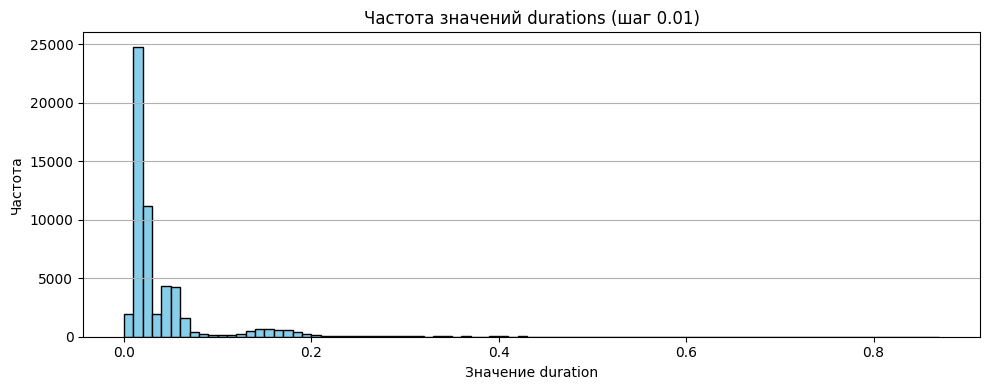

# Попытка использовать DL для решения задачи

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [ ]:
import pickle

with open('morse_data_normalize_30000.pkl', 'rb') as f:
    data = pickle.load(f)
    X = data['X']
    y = data['y']

In [ ]:
import pickle

with open('test_data_norm_5000.pkl', 'rb') as f:
    data = pickle.load(f)
    X_test = data['X_test']

In [ ]:
len(X_test)

5000

In [ ]:
len(X)

30000

In [ ]:
processed = []

for sublist in X_test:
    prev_val = 0
    true_vals = [val for flag, val in sublist if flag]
    false_vals = [val for flag, val in sublist if not flag]
    mean_true = np.mean(true_vals) if true_vals else 0
    mean_false = np.mean(false_vals) if false_vals else 0

    new_sublist = []
    for flag, val in sublist:
        diff = val - prev_val
        prev_val = val
        new_sublist.append((flag, val, abs(diff), mean_true, mean_false))

    processed.append(new_sublist)

In [ ]:
len(processed)

5000

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# X_train = X_train[:10000]
# y_train = y_train[:10000]
len(X_train)

24000

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
import random
from collections import Counter

# Установка случайного зерна для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Константы и параметры
BATCH_SIZE = 32
HIDDEN_SIZE = 128
EMBEDDING_DIM = 64
CONV_CHANNELS = 32
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.001
EPOCHS = 40

# Создание словаря символов
def create_char_dict(y_data):
    all_chars = ''.join(y_data)
    char_counts = Counter(all_chars)
    chars = sorted(char_counts.keys())
    char_to_idx = {char: idx + 1 for idx, char in enumerate(chars)}  # 0 зарезервирован для blank в CTC
    idx_to_char = {idx + 1: char for idx, char in enumerate(chars)}
    idx_to_char[0] = ''  # blank символ для CTC
    return char_to_idx, idx_to_char

# Датасет для обработки последовательностей морзе
class MorseDataset(Dataset):
    def __init__(self, X, y, char_to_idx):
        self.X = X
        self.y = y
        self.char_to_idx = char_to_idx

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Преобразование X_data в тензор (последовательность признаков)
        morse_signal = self.X[idx]
        features = torch.tensor([
              [float(value) for value in signal_tuple] for signal_tuple in morse_signal
          ], dtype=torch.float32)

        # Преобразование текста в индексы
        text = self.y[idx]
        target = torch.tensor([self.char_to_idx[char] for char in text], dtype=torch.long)

        return features, target, len(features), len(target)

# Создание коллейт-функции для преобразования batch
def collate_fn(batch):
    features, targets, feature_lengths, target_lengths = zip(*batch)

    # Паддинг последовательностей
    features_padded = pad_sequence(features, batch_first=True)
    targets_padded = pad_sequence(targets, batch_first=True)

    return features_padded, targets_padded, torch.tensor(feature_lengths), torch.tensor(target_lengths)

# Модель для распознавания кода Морзе
class MorseCodeRecognizer(nn.Module):
    def __init__(self, input_dim=2, hidden_size=128, num_classes=50):
        super(MorseCodeRecognizer, self).__init__()

        # Сверточные слои для извлечения признаков из сигнала
        self.conv_layers = nn.Sequential(
            nn.Conv1d(input_dim, CONV_CHANNELS, kernel_size=3, padding=1),
            nn.BatchNorm1d(CONV_CHANNELS),
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),

            nn.Conv1d(CONV_CHANNELS, CONV_CHANNELS * 2, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm1d(CONV_CHANNELS * 2),
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE)
        )

        # Слой для сжатия и преобразования признаков
        self.feature_projection = nn.Linear(CONV_CHANNELS * 2, EMBEDDING_DIM)

        # Двунаправленный LSTM для обработки последовательности
        self.lstm = nn.LSTM(
            input_size=EMBEDDING_DIM,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=DROPOUT_RATE,
            bidirectional=True
        )

        # Выходной слой для классификации
        self.classifier = nn.Linear(hidden_size * 2, num_classes)  # *2 из-за двунаправленности

    def forward(self, x, input_lengths):
        batch_size, seq_len, features = x.size()

        # Подготовка входа для сверточного слоя [batch, channels, seq_len]
        x = x.permute(0, 2, 1)

        # Применяем свертки
        x = self.conv_layers(x)

        # Возвращаем к формату [batch, seq_len, features] для LSTM
        x = x.permute(0, 2, 1)

        # Проекция признаков
        x = self.feature_projection(x)

        # Упаковка последовательностей для LSTM
        packed_x = pack_padded_sequence(x, input_lengths.cpu(), batch_first=True, enforce_sorted=False)

        # Применяем LSTM
        packed_output, _ = self.lstm(packed_x)

        # Распаковка
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Классификация
        logits = self.classifier(output)

        # LogSoftmax для CTC loss
        log_probs = nn.functional.log_softmax(logits, dim=2)

        return log_probs

# Функция обучения
def train_model(model, train_loader, optimizer, criterion, device, epochs):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for features, targets, feature_lengths, target_lengths in tqdm(train_loader):
            features, targets = features.to(device), targets.to(device)
            feature_lengths, target_lengths = feature_lengths.to(device), target_lengths.to(device)

            optimizer.zero_grad()

            log_probs = model(features, feature_lengths)

            # Транспонирование выхода для CTC loss (требуется [seq_len, batch, num_classes])
            log_probs_trans = log_probs.permute(1, 0, 2)

            # Вычисление CTC loss
            loss = criterion(log_probs_trans, targets, feature_lengths, target_lengths)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

# Функция декодирования
def decode_predictions(log_probs, idx_to_char, blank_idx=0):
    """
    Декодирование выходных вероятностей модели с использованием жадного декодирования (без словаря).
    """
    pred_indices = torch.argmax(log_probs, dim=2).cpu().numpy()
    decoded_outputs = []

    for pred in pred_indices:
        decoded = []
        prev_idx = -1

        for idx in pred:
            if idx != blank_idx and idx != prev_idx:  # Пропускаем повторы и blank
                decoded.append(idx_to_char[idx])
            prev_idx = idx

        decoded_outputs.append(''.join(decoded))

    return decoded_outputs

# Функция оценки
def evaluate(model, test_loader, idx_to_char, device):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for features, targets, feature_lengths, target_lengths in test_loader:
            features, targets = features.to(device), targets.to(device)
            feature_lengths = feature_lengths.to(device)

            log_probs = model(features, feature_lengths)

            predictions = decode_predictions(log_probs, idx_to_char)

            # Декодирование настоящих целей
            target_texts = []
            for i, length in enumerate(target_lengths):
                target_text = ''.join([idx_to_char[idx.item()] for idx in targets[i][:length]])
                target_texts.append(target_text)

            all_predictions.extend(predictions)
            all_targets.extend(target_texts)

    # Вычисление точности на уровне символов и последовательностей
    char_correct = 0
    char_total = 0
    seq_correct = 0

    for pred, target in zip(all_predictions, all_targets):
        if pred == target:
            seq_correct += 1

        # Вычисление расстояния Левенштейна (количества ошибок)
        matrix = [[0 for _ in range(len(target) + 1)] for _ in range(len(pred) + 1)]

        for i in range(len(pred) + 1):
            matrix[i][0] = i
        for j in range(len(target) + 1):
            matrix[0][j] = j

        for i in range(1, len(pred) + 1):
            for j in range(1, len(target) + 1):
                if pred[i-1] == target[j-1]:
                    matrix[i][j] = matrix[i-1][j-1]
                else:
                    matrix[i][j] = min(matrix[i-1][j], matrix[i][j-1], matrix[i-1][j-1]) + 1

        errors = matrix[len(pred)][len(target)]
        char_correct += len(target) - errors
        char_total += len(target)

    char_accuracy = char_correct / char_total if char_total > 0 else 0
    seq_accuracy = seq_correct / len(all_targets) if len(all_targets) > 0 else 0

    print(f"Character Accuracy: {char_accuracy:.4f}")
    print(f"Sequence Accuracy: {seq_accuracy:.4f}")

    # Примеры предсказаний
    for i in range(min(5, len(all_predictions))):
        print(f"True: {all_targets[i]}")
        print(f"Pred: {all_predictions[i]}")
        print("-" * 30)

    return char_accuracy, seq_accuracy

# Главная функция
def main(X_data, y_data):
    # Создание словаря символов
    char_to_idx, idx_to_char = create_char_dict(y_data)
    num_classes = len(char_to_idx) + 1  # +1 для blank в CTC

    # Разделение данных на обучающую и тестовую выборки
    split_idx = int(0.8 * len(X_data))
    X_train, X_test = X_data[:split_idx], X_data[split_idx:]
    y_train, y_test = y_data[:split_idx], y_data[split_idx:]

    # Создание датасетов
    train_dataset = MorseDataset(X_train, y_train, char_to_idx)
    test_dataset = MorseDataset(X_test, y_test, char_to_idx)

    # Создание даталоадеров
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    # Определение устройства
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Создание модели
    model = MorseCodeRecognizer(input_dim=5, hidden_size=HIDDEN_SIZE, num_classes=num_classes)
    model = model.to(device)

    # Оптимизатор и функция потерь
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CTCLoss(blank=0, zero_infinity=True)

    # Обучение модели
    train_model(model, train_loader, optimizer, criterion, device, EPOCHS)

    # Оценка модели
    char_accuracy, seq_accuracy = evaluate(model, test_loader, idx_to_char, device)

    # Сохранение модели
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'char_to_idx': char_to_idx,
        'idx_to_char': idx_to_char
    }, 'morse_code_recognizer.pth')

    print("Model saved as 'morse_code_recognizer.pth'")

    return model, char_to_idx, idx_to_char

# Функция для предсказания на новых данных
def predict(model, X_new, char_to_idx, idx_to_char, device):
    model.eval()

    # Подготовка данных
    features = torch.tensor([
          [float(value) for value in signal_tuple] for signal_tuple in X_new
      ], dtype=torch.float32).unsqueeze(0)  # добавление размерности батча
    feature_length = torch.tensor([len(X_new)])

    features = features.to(device)
    feature_length = feature_length.to(device)

    # Получение предсказания
    with torch.no_grad():
        log_probs = model(features, feature_length)
        prediction = decode_predictions(log_probs, idx_to_char)[0]

    return prediction

In [ ]:
model, char_to_idx, idx_to_char = main(processed, y)

Using device: cuda


100%|██████████| 750/750 [00:15<00:00, 46.90it/s]


Epoch 1/40, Loss: 4.1563


100%|██████████| 750/750 [00:16<00:00, 46.84it/s]


Epoch 2/40, Loss: 3.6143


100%|██████████| 750/750 [00:16<00:00, 45.46it/s]


Epoch 3/40, Loss: 1.3431


100%|██████████| 750/750 [00:16<00:00, 44.72it/s]


Epoch 4/40, Loss: 1.1449


100%|██████████| 750/750 [00:16<00:00, 45.95it/s]


Epoch 5/40, Loss: 1.0760


100%|██████████| 750/750 [00:15<00:00, 47.88it/s]


Epoch 6/40, Loss: 1.0247


100%|██████████| 750/750 [00:15<00:00, 47.89it/s]


Epoch 7/40, Loss: 0.9900


100%|██████████| 750/750 [00:17<00:00, 43.98it/s]


Epoch 8/40, Loss: 0.9616


100%|██████████| 750/750 [00:15<00:00, 47.96it/s]


Epoch 9/40, Loss: 0.9354


100%|██████████| 750/750 [00:15<00:00, 47.99it/s]


Epoch 10/40, Loss: 0.9159


100%|██████████| 750/750 [00:16<00:00, 45.78it/s]


Epoch 11/40, Loss: 0.8989


100%|██████████| 750/750 [00:15<00:00, 47.96it/s]


Epoch 12/40, Loss: 0.8802


100%|██████████| 750/750 [00:15<00:00, 47.86it/s]


Epoch 13/40, Loss: 0.8682


100%|██████████| 750/750 [00:16<00:00, 46.38it/s]


Epoch 14/40, Loss: 0.8529


100%|██████████| 750/750 [00:15<00:00, 47.36it/s]


Epoch 15/40, Loss: 0.8391


100%|██████████| 750/750 [00:15<00:00, 48.01it/s]


Epoch 16/40, Loss: 0.8293


100%|██████████| 750/750 [00:16<00:00, 46.62it/s]


Epoch 17/40, Loss: 0.8176


100%|██████████| 750/750 [00:15<00:00, 47.08it/s]


Epoch 18/40, Loss: 0.8078


100%|██████████| 750/750 [00:15<00:00, 47.78it/s]


Epoch 19/40, Loss: 0.7977


100%|██████████| 750/750 [00:15<00:00, 47.48it/s]


Epoch 20/40, Loss: 0.7879


100%|██████████| 750/750 [00:16<00:00, 46.11it/s]


Epoch 21/40, Loss: 0.7778


100%|██████████| 750/750 [00:15<00:00, 48.19it/s]


Epoch 22/40, Loss: 0.7706


100%|██████████| 750/750 [00:15<00:00, 47.79it/s]


Epoch 23/40, Loss: 0.7628


100%|██████████| 750/750 [00:16<00:00, 46.09it/s]


Epoch 24/40, Loss: 0.7547


100%|██████████| 750/750 [00:15<00:00, 47.74it/s]


Epoch 25/40, Loss: 0.7467


100%|██████████| 750/750 [00:15<00:00, 47.85it/s]


Epoch 26/40, Loss: 0.7422


100%|██████████| 750/750 [00:16<00:00, 45.85it/s]


Epoch 27/40, Loss: 0.7335


100%|██████████| 750/750 [00:15<00:00, 47.77it/s]


Epoch 28/40, Loss: 0.7271


100%|██████████| 750/750 [00:15<00:00, 47.62it/s]


Epoch 29/40, Loss: 0.7192


100%|██████████| 750/750 [00:16<00:00, 45.64it/s]


Epoch 30/40, Loss: 0.7139


100%|██████████| 750/750 [00:15<00:00, 47.32it/s]


Epoch 31/40, Loss: 0.7060


100%|██████████| 750/750 [00:15<00:00, 47.43it/s]


Epoch 32/40, Loss: 0.7031


100%|██████████| 750/750 [00:16<00:00, 46.04it/s]


Epoch 33/40, Loss: 0.6945


100%|██████████| 750/750 [00:15<00:00, 47.67it/s]


Epoch 34/40, Loss: 0.6908


100%|██████████| 750/750 [00:15<00:00, 47.92it/s]


Epoch 35/40, Loss: 0.6828


100%|██████████| 750/750 [00:16<00:00, 45.65it/s]


Epoch 36/40, Loss: 0.6755


100%|██████████| 750/750 [00:15<00:00, 47.81it/s]


Epoch 37/40, Loss: 0.6710


100%|██████████| 750/750 [00:15<00:00, 47.86it/s]


Epoch 38/40, Loss: 0.6697


100%|██████████| 750/750 [00:16<00:00, 46.07it/s]


Epoch 39/40, Loss: 0.6588


100%|██████████| 750/750 [00:15<00:00, 47.74it/s]


Epoch 40/40, Loss: 0.6525
Character Accuracy: 0.6865
Sequence Accuracy: 0.0220
True: 8Я1ЦЦЗТК
Pred: 8Я1ЦЦЗТК5
------------------------------
True: Е07ХЕ ЭЯФЫБЯ
Pred: Ю7БХЕ ЭЛМБП5
------------------------------
True: 3Ф 74ИП58 6
Pred: 3Ф 74ИП58 6
------------------------------
True: Щ4ЙЙ8Г#7
Pred: Щ4ЙЙ8Г#75
------------------------------
True: 1Б Д76 Л0#
Pred: 1Б Д7ТС Л0#5
------------------------------
Model saved as 'morse_code_recognizer.pth'


Попытка улучшить модель, добавив Resnet слой

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
import random
from collections import Counter

# Установка случайного зерна для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Константы и параметры
BATCH_SIZE = 32
HIDDEN_SIZE = 128
EMBEDDING_DIM = 64
CONV_CHANNELS = 32
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.001
EPOCHS = 40

class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3, dropout=DROPOUT_RATE):
      super(ResidualBlock, self).__init__()
      self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size//2)
      self.bn1 = nn.BatchNorm1d(out_channels)
      self.relu = nn.ReLU()
      self.dropout = nn.Dropout(dropout)
      self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size//2)
      self.bn2 = nn.BatchNorm1d(out_channels)

      self.residual_connection = nn.Sequential()
      if in_channels != out_channels:
          self.residual_connection = nn.Conv1d(in_channels, out_channels, kernel_size=1)

  def forward(self, x):
      residual = self.residual_connection(x)
      out = self.conv1(x)
      out = self.bn1(out)
      out = self.relu(out)
      out = self.dropout(out)
      out = self.conv2(out)
      out = self.bn2(out)
      out += residual
      out = self.relu(out)
      return out

class MorseCodeRecognizer(nn.Module):
  def __init__(self, input_dim=5, conv_channels=64, embedding_dim=EMBEDDING_DIM, num_classes=50, num_transformer_layers=4, num_heads=4):
      super(MorseCodeRecognizer, self).__init__()

      # Реснет блоки
      self.initial_conv = nn.Conv1d(input_dim, conv_channels, kernel_size=3, padding=1)
      self.res_block1 = ResidualBlock(conv_channels, conv_channels)
      self.res_block2 = ResidualBlock(conv_channels, conv_channels * 2)
      self.res_block3 = ResidualBlock(conv_channels * 2, conv_channels * 2)

      self.feature_projection = nn.Linear(conv_channels * 2, embedding_dim)

      # Transformer Encoder
      encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=embedding_dim * 4, dropout=DROPOUT_RATE, batch_first=True)
      self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)

      # Классификатор
      self.classifier = nn.Linear(embedding_dim, num_classes)

  def forward(self, x, input_lengths):
      x = x.permute(0, 2, 1)  # [B, C, T]

      x = self.initial_conv(x)
      x = self.res_block1(x)
      x = self.res_block2(x)
      x = self.res_block3(x)

      x = x.permute(0, 2, 1)  # [B, T, C]
      x = self.feature_projection(x)

      # Маска для transformer (True — пропущенные, False — полезные)
      max_len = x.size(1)
      mask = torch.arange(max_len, device=input_lengths.device)[None, :] >= input_lengths[:, None]

      x = self.transformer_encoder(x, src_key_padding_mask=mask)

      logits = self.classifier(x)
      log_probs = nn.functional.log_softmax(logits, dim=2)

      return log_probs

# Создание словаря символов
def create_char_dict(y_data):
    all_chars = ''.join(y_data)
    char_counts = Counter(all_chars)
    chars = sorted(char_counts.keys())
    char_to_idx = {char: idx + 1 for idx, char in enumerate(chars)}  # 0 зарезервирован для blank в CTC
    idx_to_char = {idx + 1: char for idx, char in enumerate(chars)}
    idx_to_char[0] = ''  # blank символ для CTC
    return char_to_idx, idx_to_char

# Датасет для обработки последовательностей морзе
class MorseDataset(Dataset):
    def __init__(self, X, y, char_to_idx):
        self.X = X
        self.y = y
        self.char_to_idx = char_to_idx

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Преобразование X_data в тензор (последовательность признаков)
        morse_signal = self.X[idx]
        features = torch.tensor([
              [float(value) for value in signal_tuple] for signal_tuple in morse_signal
          ], dtype=torch.float32)

        # Преобразование текста в индексы
        text = self.y[idx]
        target = torch.tensor([self.char_to_idx[char] for char in text], dtype=torch.long)

        return features, target, len(features), len(target)

# Создание коллейт-функции для преобразования batch
def collate_fn(batch):
    features, targets, feature_lengths, target_lengths = zip(*batch)

    # Паддинг последовательностей
    features_padded = pad_sequence(features, batch_first=True)
    targets_padded = pad_sequence(targets, batch_first=True)

    return features_padded, targets_padded, torch.tensor(feature_lengths), torch.tensor(target_lengths)

# Модель для распознавания кода Морзе

# Функция обучения
def train_model(model, train_loader, optimizer, criterion, device, epochs):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for features, targets, feature_lengths, target_lengths in tqdm(train_loader):
            features, targets = features.to(device), targets.to(device)
            feature_lengths, target_lengths = feature_lengths.to(device), target_lengths.to(device)

            optimizer.zero_grad()

            log_probs = model(features, feature_lengths)

            # Транспонирование выхода для CTC loss (требуется [seq_len, batch, num_classes])
            log_probs_trans = log_probs.permute(1, 0, 2)

            # Вычисление CTC loss
            loss = criterion(log_probs_trans, targets, feature_lengths, target_lengths)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

# Функция декодирования
def decode_predictions(log_probs, idx_to_char, blank_idx=0):
    """
    Декодирование выходных вероятностей модели с использованием жадного декодирования (без словаря).
    """
    pred_indices = torch.argmax(log_probs, dim=2).cpu().numpy()
    decoded_outputs = []

    for pred in pred_indices:
        decoded = []
        prev_idx = -1

        for idx in pred:
            if idx != blank_idx and idx != prev_idx:  # Пропускаем повторы и blank
                decoded.append(idx_to_char[idx])
            prev_idx = idx

        decoded_outputs.append(''.join(decoded))

    return decoded_outputs

# Функция оценки
def evaluate(model, test_loader, idx_to_char, device):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for features, targets, feature_lengths, target_lengths in test_loader:
            features, targets = features.to(device), targets.to(device)
            feature_lengths = feature_lengths.to(device)

            log_probs = model(features, feature_lengths)

            predictions = decode_predictions(log_probs, idx_to_char)

            # Декодирование настоящих целей
            target_texts = []
            for i, length in enumerate(target_lengths):
                target_text = ''.join([idx_to_char[idx.item()] for idx in targets[i][:length]])
                target_texts.append(target_text)

            all_predictions.extend(predictions)
            all_targets.extend(target_texts)

    # Вычисление точности на уровне символов и последовательностей
    char_correct = 0
    char_total = 0
    seq_correct = 0

    for pred, target in zip(all_predictions, all_targets):
        if pred == target:
            seq_correct += 1

        # Вычисление расстояния Левенштейна (количества ошибок)
        matrix = [[0 for _ in range(len(target) + 1)] for _ in range(len(pred) + 1)]

        for i in range(len(pred) + 1):
            matrix[i][0] = i
        for j in range(len(target) + 1):
            matrix[0][j] = j

        for i in range(1, len(pred) + 1):
            for j in range(1, len(target) + 1):
                if pred[i-1] == target[j-1]:
                    matrix[i][j] = matrix[i-1][j-1]
                else:
                    matrix[i][j] = min(matrix[i-1][j], matrix[i][j-1], matrix[i-1][j-1]) + 1

        errors = matrix[len(pred)][len(target)]
        char_correct += len(target) - errors
        char_total += len(target)

    char_accuracy = char_correct / char_total if char_total > 0 else 0
    seq_accuracy = seq_correct / len(all_targets) if len(all_targets) > 0 else 0

    print(f"Character Accuracy: {char_accuracy:.4f}")
    print(f"Sequence Accuracy: {seq_accuracy:.4f}")

    # Примеры предсказаний
    for i in range(min(5, len(all_predictions))):
        print(f"True: {all_targets[i]}")
        print(f"Pred: {all_predictions[i]}")
        print("-" * 30)

    return char_accuracy, seq_accuracy

# Главная функция
def main(X_data, y_data):
    # Создание словаря символов
    char_to_idx, idx_to_char = create_char_dict(y_data)
    num_classes = len(char_to_idx) + 1  # +1 для blank в CTC

    # Разделение данных на обучающую и тестовую выборки
    split_idx = int(0.8 * len(X_data))
    X_train, X_test = X_data[:split_idx], X_data[split_idx:]
    y_train, y_test = y_data[:split_idx], y_data[split_idx:]

    # Создание датасетов
    train_dataset = MorseDataset(X_train, y_train, char_to_idx)
    test_dataset = MorseDataset(X_test, y_test, char_to_idx)

    # Создание даталоадеров
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    # Определение устройства
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Создание модели
    model = MorseCodeRecognizer(input_dim=5, num_classes=num_classes)
    model = model.to(device)

    # Оптимизатор и функция потерь
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CTCLoss(blank=0, zero_infinity=True)

    # Обучение модели
    train_model(model, train_loader, optimizer, criterion, device, EPOCHS)

    # Оценка модели
    char_accuracy, seq_accuracy = evaluate(model, test_loader, idx_to_char, device)

    # Сохранение модели
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'char_to_idx': char_to_idx,
        'idx_to_char': idx_to_char
    }, 'morse_code_recognizer.pth')

    print("Model saved as 'morse_code_recognizer.pth'")

    return model, char_to_idx, idx_to_char

# Функция для предсказания на новых данных
def predict(model, X_new, char_to_idx, idx_to_char, device):
    model.eval()

    # Подготовка данных
    features = torch.tensor([
          [float(value) for value in signal_tuple] for signal_tuple in X_new
      ], dtype=torch.float32).unsqueeze(0)  # добавление размерности батча
    feature_length = torch.tensor([len(X_new)])

    features = features.to(device)
    feature_length = feature_length.to(device)

    # Получение предсказания
    with torch.no_grad():
        log_probs = model(features, feature_length)
        prediction = decode_predictions(log_probs, idx_to_char)[0]

    return prediction

In [ ]:
model, char_to_idx, idx_to_char = main(processed, y)

Using device: cuda


100%|██████████| 750/750 [00:16<00:00, 46.20it/s]


Epoch 1/40, Loss: 4.1169


100%|██████████| 750/750 [00:13<00:00, 53.75it/s]


Epoch 2/40, Loss: 3.9233


100%|██████████| 750/750 [00:13<00:00, 54.02it/s]


Epoch 3/40, Loss: 1.8514


100%|██████████| 750/750 [00:14<00:00, 53.54it/s]


Epoch 4/40, Loss: 1.1799


100%|██████████| 750/750 [00:13<00:00, 53.86it/s]


Epoch 5/40, Loss: 1.1040


100%|██████████| 750/750 [00:14<00:00, 52.59it/s]


Epoch 6/40, Loss: 1.0619


100%|██████████| 750/750 [00:14<00:00, 52.33it/s]


Epoch 7/40, Loss: 1.0317


100%|██████████| 750/750 [00:13<00:00, 53.78it/s]


Epoch 8/40, Loss: 1.0106


100%|██████████| 750/750 [00:13<00:00, 53.82it/s]


Epoch 9/40, Loss: 0.9930


100%|██████████| 750/750 [00:13<00:00, 53.77it/s]


Epoch 10/40, Loss: 0.9796


100%|██████████| 750/750 [00:14<00:00, 52.99it/s]


Epoch 11/40, Loss: 0.9667


100%|██████████| 750/750 [00:14<00:00, 51.70it/s]


Epoch 12/40, Loss: 0.9568


100%|██████████| 750/750 [00:14<00:00, 52.99it/s]


Epoch 13/40, Loss: 0.9467


100%|██████████| 750/750 [00:14<00:00, 53.45it/s]


Epoch 14/40, Loss: 0.9412


100%|██████████| 750/750 [00:13<00:00, 53.82it/s]


Epoch 15/40, Loss: 0.9316


100%|██████████| 750/750 [00:13<00:00, 53.99it/s]


Epoch 16/40, Loss: 0.9265


100%|██████████| 750/750 [00:13<00:00, 53.88it/s]


Epoch 17/40, Loss: 0.9188


100%|██████████| 750/750 [00:14<00:00, 51.32it/s]


Epoch 18/40, Loss: 0.9135


100%|██████████| 750/750 [00:13<00:00, 53.66it/s]


Epoch 19/40, Loss: 0.9075


100%|██████████| 750/750 [00:13<00:00, 53.77it/s]


Epoch 20/40, Loss: 0.9031


100%|██████████| 750/750 [00:13<00:00, 53.73it/s]


Epoch 21/40, Loss: 0.8974


100%|██████████| 750/750 [00:13<00:00, 53.83it/s]


Epoch 22/40, Loss: 0.8941


100%|██████████| 750/750 [00:14<00:00, 53.30it/s]


Epoch 23/40, Loss: 0.8885


100%|██████████| 750/750 [00:14<00:00, 51.98it/s]


Epoch 24/40, Loss: 0.8863


100%|██████████| 750/750 [00:14<00:00, 53.45it/s]


Epoch 25/40, Loss: 0.8827


100%|██████████| 750/750 [00:13<00:00, 53.99it/s]


Epoch 26/40, Loss: 0.8796


100%|██████████| 750/750 [00:14<00:00, 53.51it/s]


Epoch 27/40, Loss: 0.8745


100%|██████████| 750/750 [00:13<00:00, 53.81it/s]


Epoch 28/40, Loss: 0.8716


100%|██████████| 750/750 [00:14<00:00, 52.70it/s]


Epoch 29/40, Loss: 0.8694


100%|██████████| 750/750 [00:14<00:00, 52.57it/s]


Epoch 30/40, Loss: 0.8653


100%|██████████| 750/750 [00:13<00:00, 53.83it/s]


Epoch 31/40, Loss: 0.8650


100%|██████████| 750/750 [00:14<00:00, 53.39it/s]


Epoch 32/40, Loss: 0.8609


100%|██████████| 750/750 [00:13<00:00, 53.86it/s]


Epoch 33/40, Loss: 0.8592


100%|██████████| 750/750 [00:14<00:00, 51.65it/s]


Epoch 34/40, Loss: 0.8558


100%|██████████| 750/750 [00:14<00:00, 50.86it/s]


Epoch 35/40, Loss: 0.8506


100%|██████████| 750/750 [00:14<00:00, 53.55it/s]


Epoch 36/40, Loss: 0.8506


100%|██████████| 750/750 [00:13<00:00, 53.69it/s]


Epoch 37/40, Loss: 0.8480


100%|██████████| 750/750 [00:13<00:00, 53.92it/s]


Epoch 38/40, Loss: 0.8462


100%|██████████| 750/750 [00:13<00:00, 53.82it/s]


Epoch 39/40, Loss: 0.8457


100%|██████████| 750/750 [00:14<00:00, 53.35it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Epoch 40/40, Loss: 0.8421
Character Accuracy: 0.7783
Sequence Accuracy: 0.4040
True: 8Я1ЦЦЗТК
Pred: 8Я1ЦЦЗТК
------------------------------
True: Е07ХЕ ЭЯФЫБЯ
Pred: 0БХЕ ЭРМБП
------------------------------
True: 3Ф 74ИП58 6
Pred: 3Ф 74ИП58 6
------------------------------
True: Щ4ЙЙ8Г#7
Pred: Щ4ЙЙ8Г#7
------------------------------
True: 1Б Д76 Л0#
Pred: 1Б Д7ТС Л0#
------------------------------
Model saved as 'morse_code_recognizer.pth'
